## Importing Libraries

In [3]:
import numpy as np # Numpy is the building block of the other libraries we will use
import cv2 #Open CV is used for image processing 
from sklearn.cluster import KMeans 
# The un-supervised algorithm we will use to to cluster the pixel data based on the RBG values
from collections import Counter #This library is useful for counting labels 
import imutils # This library is useful for image processing 
import pprint # This library is useful for pretty printing data 
import matplotlib.pyplot as plt # This is a useful graph plotting library 


## Take Image From Computer Webcam

In [11]:
### This will take a screenshot of the face 
cap = cv2.VideoCapture(0) # Most webcams require the number 0, but it is a number that will have to be tested for various computers can range from (0,10)


while(True):
    ret,frame = cap.read() # return a single frame in variable 'frame'
    cv2.imshow('img1',frame) # display the captured image
    
    if cv2.waitKey(1) & 0xFF == ord('y'): # It will take and save the Image by Pressing on 'Y' on keyboard 
        cv2.imwrite('face.png',frame) #This will save the image as face.png in the images folder
        cv2.destroyAllWindows()
        break

cap.release() 
cv2.destroyAllWindows()
for i in range(1,5): # This will shut down the frame properly 
    cv2.waitKey(1)
### screenshot saved in folder

In [12]:
image = cv2.imread('face.png')

In [13]:
min_HSV = np.array([0, 48, 30], dtype = "uint8")
max_HSV = np.array([33, 255, 255], dtype = "uint8")
# Get pointer to video frames from primary device
image = cv2.imread("face.png")
imageHSV = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
skinRegionHSV = cv2.inRange(imageHSV, min_HSV, max_HSV)

skinHSV = cv2.bitwise_and(image, image, mask = skinRegionHSV)

cv2.imwrite("faceshot.png", np.hstack([image, skinHSV]))

True

In [14]:
def extractSkin(image):
    # Taking a copy of the image
    #img = image.copy()
    # Converting from BGR Colours Space to HSV 
    img = image.copy()
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # Defining HSV Threadholds
    lower_threshold = np.array([0, 48, 80], dtype=np.uint8)
    upper_threshold = np.array([20, 255, 255], dtype=np.uint8)

    # Single Channel mask,denoting presence of colours in the about threshold
    skinMask = cv2.inRange(img, lower_threshold, upper_threshold)

    # Cleaning up mask using Gaussian Filter
    skinMask = cv2.GaussianBlur(skinMask, (3, 3), 0)

    # Extracting skin from the threshold mask
    skin = cv2.bitwise_and(img, img, mask=skinMask)

    # Return the Skin image
    return cv2.cvtColor(skin, cv2.COLOR_HSV2BGR)

In [15]:
def removeBlack(estimator_labels, estimator_cluster):

    # Check for black
    hasBlack = False

    # Get the total number of occurance for each color
    occurance_counter = Counter(estimator_labels)

    # Quick lambda function to compare to lists
    def compare(x, y): return Counter(x) == Counter(y)

    # Loop through the most common occuring color
    for x in occurance_counter.most_common(len(estimator_cluster)):

        # Quick List comprehension to convert each of RBG Numbers to int
        color = [int(i) for i in estimator_cluster[x[0]].tolist()]

        # Check if the color is [0,0,0] that if it is black
        if compare(color, [0, 0, 0]) == True:
            # delete the occurance
            del occurance_counter[x[0]]
            # remove the cluster
            hasBlack = True
            estimator_cluster = np.delete(estimator_cluster, x[0], 0)
            break

    return (occurance_counter, estimator_cluster, hasBlack)

In [16]:
def getColorInformation(estimator_labels, estimator_cluster, hasThresholding=False):

    # Variable to keep count of the occurance of each color predicted
    occurance_counter = None

    # Output list variable to return
    colorInformation = []

    # Check for Black
    hasBlack = False

    # If a mask has be applied, remove th black
    if hasThresholding == True:

        (occurance, cluster, black) = removeBlack(
            estimator_labels, estimator_cluster)
        occurance_counter = occurance
        estimator_cluster = cluster
        hasBlack = black

    else:
        occurance_counter = Counter(estimator_labels)

    # Get the total sum of all the predicted occurances
    totalOccurance = sum(occurance_counter.values())

    # Loop through all the predicted colors
    for x in occurance_counter.most_common(len(estimator_cluster)):
        index = (int(x[0]))

        # Quick fix for index out of bound when there is no threshold
        index = (index-1) if ((hasThresholding & hasBlack)
                              & (int(index) != 0)) else index

        # Get the color number into a list
        color = estimator_cluster[index].tolist()

        # Get the percentage of each color
        color_percentage = (x[1]/totalOccurance)

        # make the dictionay of the information
        colorInfo = {"cluster_index": index, "color": color,
                     "color_percentage": color_percentage}

        # Add the dictionary to the list
        colorInformation.append(colorInfo)

    return colorInformation

In [17]:
def extractDominantColor(image, number_of_colors=5, hasThresholding=False):

    # Quick Fix Increase cluster counter to neglect the black(Read Article)
    if hasThresholding == True:
        number_of_colors += 1

    # Taking Copy of the image
    img = image.copy()

    # Convert Image into RGB Colours Space
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Reshape Image
    img = img.reshape((img.shape[0]*img.shape[1]), 3)

    # Initiate KMeans Object
    estimator = KMeans(n_clusters=number_of_colors, random_state=0)

    # Fit the image
    estimator.fit(img)

    # Get Colour Information
    colorInformation = getColorInformation(
        estimator.labels_, estimator.cluster_centers_, hasThresholding)
    return colorInformation

In [18]:
def plotColorBar(colorInformation):
    # Create a 500x100 black image
    color_bar = np.zeros((100, 500, 3), dtype="uint8")

    top_x = 0
    for x in colorInformation:
        bottom_x = top_x + (x["color_percentage"] * color_bar.shape[1])

        color = tuple(map(int, (x['color'])))

        cv2.rectangle(color_bar, (int(top_x), 0),
                      (int(bottom_x), color_bar.shape[0]), color, -1)
        top_x = bottom_x
    return color_bar

In [19]:
def prety_print_data(color_info):
    for x in color_info:
        print(pprint.pformat(x))
        print()

In [20]:
# resize the image to a width of 250
image = imutils.resize(image, width=250)

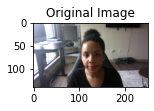

In [21]:
plt.subplot(3, 1, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.show();

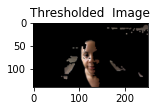

In [22]:

# Apply Skin Mask

skin = extractSkin(image)


plt.subplot(3, 1, 2)
plt.imshow(cv2.cvtColor(skin, cv2.COLOR_BGR2RGB))
plt.title("Thresholded  Image")
plt.show();

In [23]:
# Find the dominant color. Default is 1 , pass the parameter 'number_of_colors=N' where N is the specified number of colors
dominantColors = extractDominantColor(skin, hasThresholding=True)

In [24]:
# Show in the dominant color information
print("Color Information")
prety_print_data(dominantColors)

Color Information
{'cluster_index': 2,
 'color': [79.29471890971007, 54.2172061328791, 42.46592844974431],
 'color_percentage': 0.3120042305658382}

{'cluster_index': 1,
 'color': [104.9362445414843, 85.29344978165952, 73.72751091703074],
 'color_percentage': 0.30142781597038604}

{'cluster_index': 4,
 'color': [140.56919060052167, 110.85509138381227, 94.82506527415171],
 'color_percentage': 0.20227392913802222}

{'cluster_index': 3,
 'color': [231.95505617977474, 199.68820224719127, 182.94382022471922],
 'color_percentage': 0.09439450026441036}

{'cluster_index': 0,
 'color': [187.14662756598224, 151.31378299120212, 132.14369501466254],
 'color_percentage': 0.0898995240613432}



Color Bar


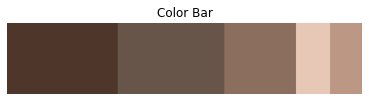

In [25]:
# Show in the dominant color as bar
print("Color Bar")
colour_bar = plotColorBar(dominantColors)
plt.subplot(3, 1, 3)
plt.axis("off")
plt.imshow(colour_bar)
plt.title("Color Bar")

plt.tight_layout()
plt.show()

In [26]:

example = dominantColors[0]['color']
example

[79.29471890971007, 54.2172061328791, 42.46592844974431]